In [42]:
%load_ext autoreload
%autoreload 2

import os
import struct
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import gfft

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note, GFFT only works on Python 2

In [43]:
FNAME = '/project/druhe/SB320-202012281240-lba_outer.vis'

MAGIC = '0x000000003B98F002'
int(MAGIC, 0)


999878658

In [44]:
NANT = 576
SUB = 320
NCHAN = 1
POL2REC = 4
LEN_HDR = 512
NBLINE = NANT * (NANT + 1) // 2
PAYLOAD = NBLINE * NCHAN * POL2REC * 8# Final *2 unknown
RECSIZE = PAYLOAD + LEN_HDR

fsize = os.path.getsize(FNAME)
nrec = fsize // RECSIZE
nrec

418

In [45]:
def read_vis(f):
    s = f.read(RECSIZE)

    header = s[:512]
    data = s[512:]

    magic, = struct.unpack("<Q", s[0:8])
    magic = np.uint32(magic)
    assert int(magic) == int(MAGIC, 0)
    
    data = np.reshape(np.frombuffer(data, dtype=np.complex64), (NBLINE, NCHAN, POL2REC))
    return data

In [47]:
# xx, xy, yx, yy
with open(FNAME, 'rb') as f:
    
    f.seek(0 * RECSIZE)

    vis = read_vis(f)
data = vis.copy()    
data.shape


(166176, 1, 4)

In [48]:
data = (data - data.mean()) / data.std()

In [49]:
from parse_lba_antennafield import parse_lba_antennafield
L, in_ax = parse_lba_antennafield('../antennafields/a12-AntennaField.conf', [SUB])
# L = parse_lba_antennafield('../antennafields/a12-AntennaField.conf', [288])

In [50]:
L_2d = L[:, :2]
distances = L_2d[:, None] - L_2d

Text(0.5,1,'Antenna locations A12')

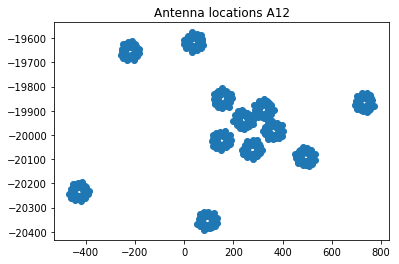

In [51]:
plt.scatter(L_2d[:, 0], L_2d[:, 1])
plt.title('Antenna locations A12')

In [52]:
from scipy.constants import c
meters_to_wavelengths = 2 * SUB * 2e8 / (1024  * c)  # frequency over speed is wavelength

In [53]:
u, v = meters_to_wavelengths * distances[np.tril_indices(len(distances))].T


In [227]:
correlation_matrix = np.zeros([3, 576, 576])

In [ ]:
u, v = distances

Text(0.5,1,'UV coverage A12')

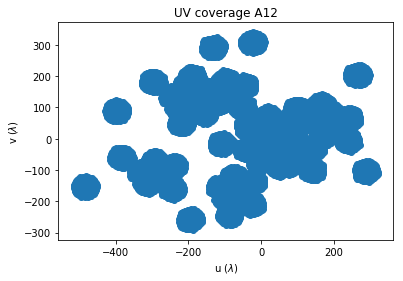

In [54]:
plt.scatter(u, v)
plt.xlabel(r'u ($\lambda$)')
plt.ylabel(r'v ($\lambda$)')
plt.title('UV coverage A12')

In [55]:
# Change to diagonal correlation matrix to view which baselines are bad.

covar_matrix = np.full([576, 576], 0j)
covar_matrix[np.tril_indices_from(covar_matrix)] = data[:, 0, 0]



Text(0.5,1,'SB320-202012281240-lba_outer.vis covariance matrix')

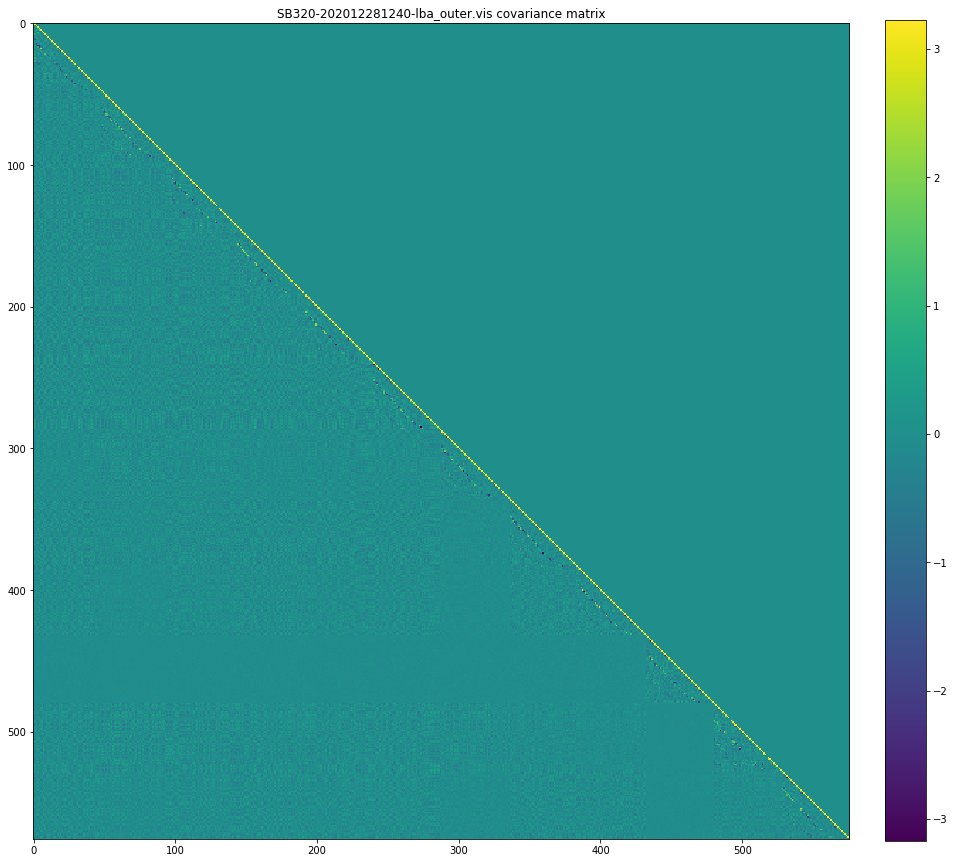

In [56]:
import seaborn as sns
from matplotlib.colors import LogNorm

# sns.set_context('notebook')
# sns.set_style('whitegrid')
plt.figure(figsize=(16, 16))
plt.imshow(np.real(covar_matrix), 
           vmin=np.real(covar_matrix).mean() - 3 * np.real(covar_matrix).std(), 
           vmax=np.real(covar_matrix).mean() + 3 * np.real(covar_matrix).std())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SB320-202012281240-lba_outer.vis covariance matrix')

In [57]:
res = 2300
dx = 1.0 / res
out_ax = [(dx, res), (dx, res)]
 

In [58]:
covar_matrix = np.full([576, 576], 0j)
covar_matrix[np.tril_indices_from(covar_matrix)] = data[:, 0, 0]


In [59]:
L = np.linspace(-1, 1, res)
M = np.linspace(-1, 1, res) 
mask = np.ones((res, res))
xv, yv = np.meshgrid(L, M)
# mask[np.sqrt(np.array(xv**2 + yv**2)) > 1] = np.nan


In [60]:
# Change to diagonal correlation matrix to view which baselines are bad.
# Look at amplitudes as function of antenna.
data.shape

(166176, 1, 4)

In [61]:
image = data.copy()

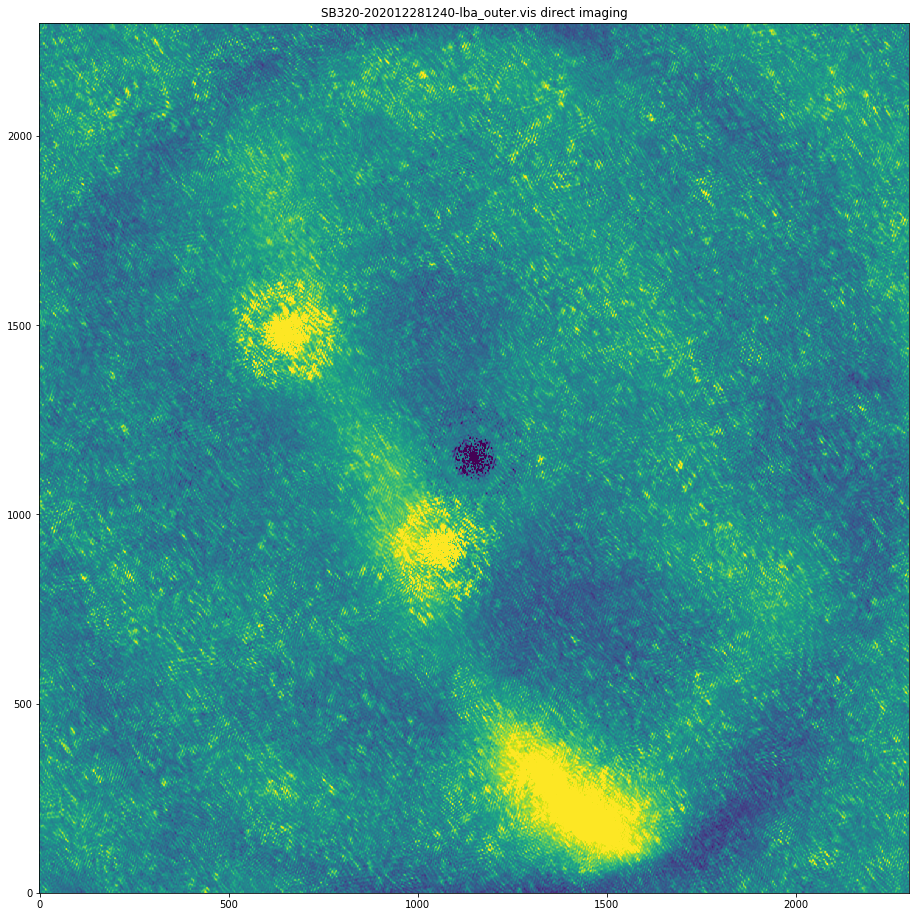

In [63]:
im = image.mean(axis=(-1, -2))

im = np.rot90(np.real(gfft.gfft(np.ravel(im), [u, v], out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask


plt.figure(figsize=(16, 16))
plt.imshow(im, vmin=np.nanmean(im) - 3 * np.nanstd(im), vmax=np.nanmean(im) + 3 * np.nanstd(im), origin='lower')
plt.title('SB320-202012281240-lba_outer.vis direct imaging')
plt.show()



In [65]:
# ds = ds[~np.eye(576, dtype=bool)]

In [67]:
visibilities = data.mean((-1, -2))

In [68]:
vis_u_v = np.stack([visibilities, u, v])

In [69]:
vis_u_v.shape

(3, 166176)

In [70]:
covar_matrix = np.zeros([3, 576, 576], dtype=complex)

In [71]:
covar_matrix[(slice(None),) + np.tril_indices(576)] = vis_u_v

In [72]:
covar_matrix_full = covar_matrix + np.swapaxes(covar_matrix, -1, -2)

Text(0.5,1,'SB320-202012281240-lba_outer.vis covariance matrix')

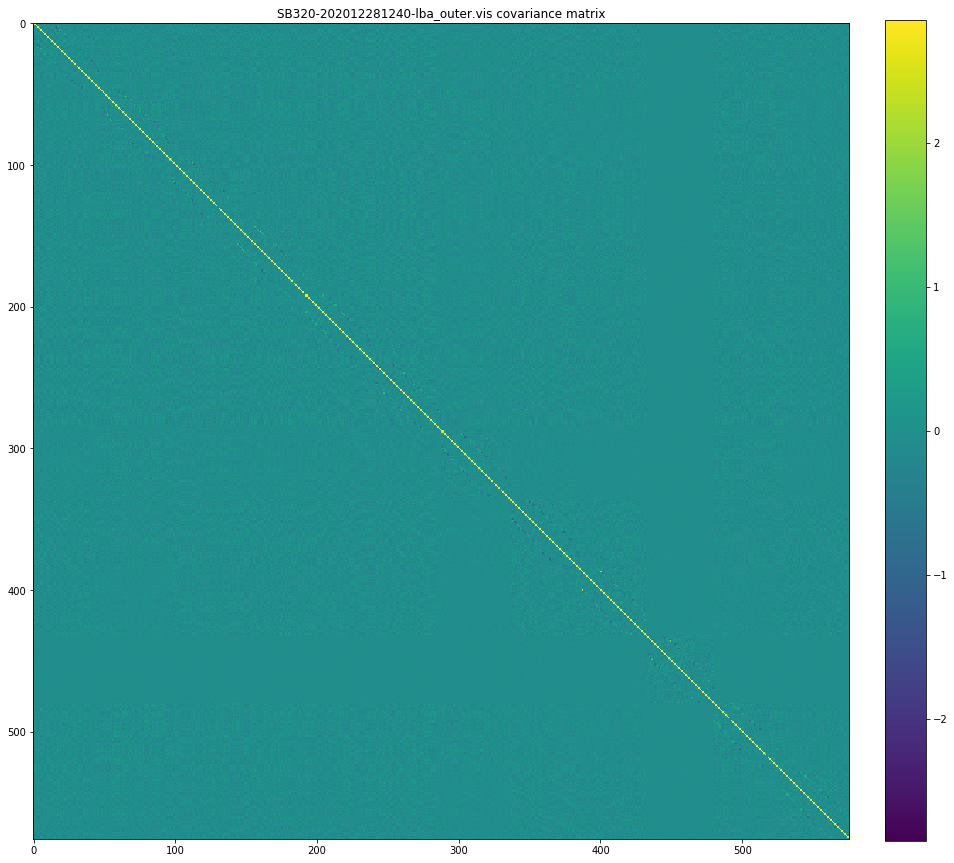

In [215]:
import seaborn as sns
from matplotlib.colors import LogNorm

plt.figure(figsize=(16, 16))
plt.imshow(np.real(covar_matrix_full[0]), 
           vmin=np.real(covar_matrix_full[0]).mean() - 3 * np.real(covar_matrix_full[0]).std(), 
           vmax=np.real(covar_matrix_full[0]).mean() + 3 * np.real(covar_matrix_full[0]).std())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SB320-202012281240-lba_outer.vis covariance matrix')

In [216]:
covar_matrix_no_auto = covar_matrix[:, ~np.eye(576, dtype=bool)]

In [217]:
covar_matrix_no_auto.shape

(3, 331200)

In [218]:
uv_indices = covar_matrix_no_auto[1:].copy()
uv_indices[0, :] = uv_indices[0, :] - uv_indices[0, :].min()
uv_indices[1, :] = uv_indices[1, :] - uv_indices[1, :].min()
uv_indices = uv_indices.astype(int)

uv = np.zeros([uv_indices[1, :].max().astype(int) + 1, uv_indices[0, :].max().astype(int) + 1])

/home/druhe/projects/interferometry/.venv_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [219]:
uv.shape

(632, 837)

In [127]:
uv[uv_indices[1, :], uv_indices[0, :]] = covar_matrix_no_auto[0]

/home/druhe/projects/interferometry/.venv_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


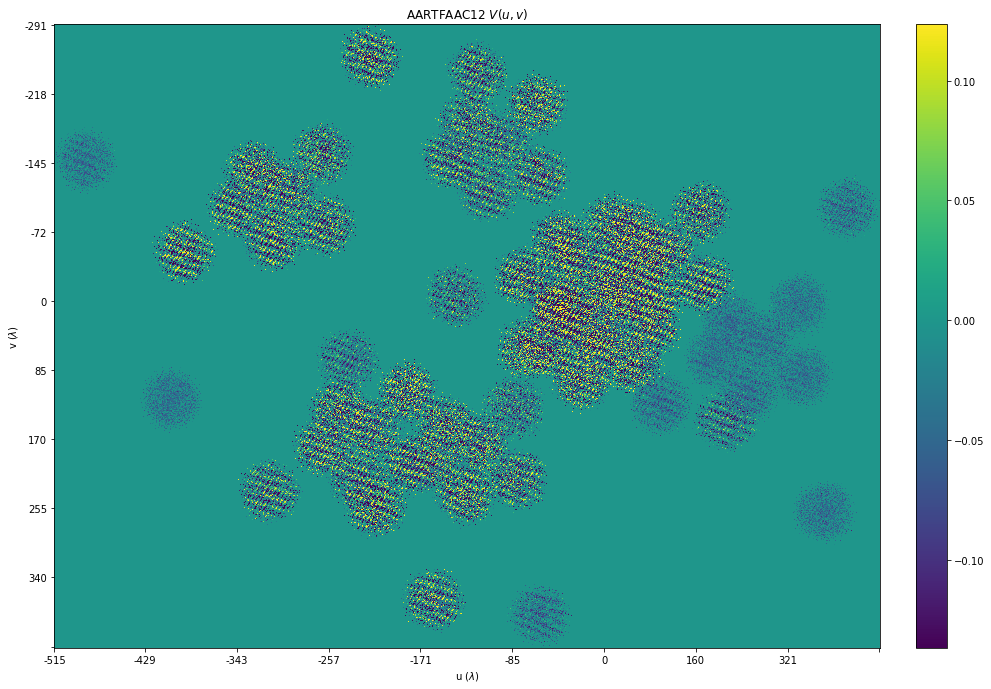

In [210]:
plt.figure(figsize=(16, 16), facecolor='white')
plt.imshow(uv, 
           vmin=uv.mean() - 3 * uv.std(), 
           vmax=uv.mean() + 3 * uv.std(), )
#            extent=[-uv.shape[1]/2., uv.shape[1]/2., -uv.shape[0]/2., uv.shape[0]/2. ])
plt.title(r'AARTFAAC12 $V(u, v)$')
plt.ylabel(r'v $(\lambda)$')
plt.xlabel(r'u $(\lambda)$')

locs_u = np.linspace(0, uv_indices[0].max(), 10).astype(int)
less_than_null_u = np.linspace(u.min(), 0, int((0 - u.min()) / (u.max() - u.min()) * 10), endpoint=False)
greater_than_null_u = np.linspace(0, u.max(), int((u.max() - 0) / (u.max() - u.min()) * 10))
vs_u = np.concatenate([less_than_null_u, greater_than_null_u])
plt.xticks(locs_u, vs_u.astype(int))

locs_v = np.linspace(0, uv_indices[1].max(), 10).astype(int)
less_than_null_v = np.linspace(v.min(), 0, int((0 - v.min()) / (v.max() - v.min()) * 10), endpoint=False)
greater_than_null_v = np.linspace(0, v.max(), int((v.max() - 0) / (v.max() - v.min()) * 10))
vs_v = np.concatenate([less_than_null_v, greater_than_null_v])
plt.yticks(locs_v, vs_v.astype(int))

plt.colorbar(fraction=0.035, pad=0.04)
# plt.xticks(np.linspace(0, u.m))
# plt.xticks(np.linspace(u.min(), u.max() + 1, 10))
